## Tugas Besar IF3270 Pembelajaran Mesin Artificial Neural Network

### Bagian B: Implementasi Mini-Batch Gradient Descent untuk Feed Forward Neural Network
Jaringan saraf tiruan pada bagian feed forward neural network (FFNN) menggunakan bahasa python.

### Kelompok 1
- 13520004 Gede Prasidha Bhawarnawa
- 13521076 Moh. Aghna Maysan Abyan
- 13521110 Yanuar Sano Nur Rasyid
- 13521152 Muhammad Naufal Nalendra

In [38]:
# Import necessary libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import sys
import json

Fungsi aktivasi

In [39]:
# Softmax Activation Function Implementation
def softmax(arr):
    arr = np.array(arr)
    arr = np.exp(arr)
    sum_arr = np.sum(arr)
    return arr/sum_arr

In [40]:
# Sigmoid Activation Function Implementation
def sigmoid(arr):
    numerator = np.exp(arr)
    denominator = numerator + 1
    return numerator / denominator

In [41]:
# Linear Activation Function Implementation
def linear(arr):
    return arr

In [42]:
# Rectified Linear Unit (ReLU) Activation Function Implementation
def relu(val):
    if val < 0:
        return 0
    else:
        return val

In [43]:
def countSSError(results, expected_results):
    results = np.array(results)
    expected_results = np.array(expected_results)
    if results.shape != expected_results.shape:
        print("Error: array shape mismatch")
        sys.exit(1)
    else:
        return np.sum(np.square(results - expected_results))

Derivatif (turunan) fungsi aktivasi

In [44]:
def derivative_relu(val):
    if val < 0:
        return 0
    else:
        return 1

In [45]:
def derivative_sigmoid(val):
    return val * (1 - val)

In [46]:
def derivative_linear(val):
    return 1

In [47]:
def derivativeSoftmax(value, isTrueClass):
    if isTrueClass:
        return -1 * (1 - value)
    else:
        return value

Implementasi

In [114]:
# Node Class and Instances
class Node:
    def __init__(self, node_number, node_type, node_level, activation_function, weight, node_value=0):
        self.node_number = node_number
        self.node_type = node_type
        self.node_in_value = node_value # Added for tubes bagian B
        self.node_out_value = node_value # For non-input nodes, this value is 0 initially
        self.node_level = node_level
        self.activation_function = activation_function
        self.weight = weight
        # Updated for tubes bagian B
        self.target_output = 0 # 0 for non-output nodes
        self.error = 0
        self.derivative_value = 0
        self.pending_weight_change = {}
    
    def getNodeNumber(self):
        return self.node_number
    
    def getNodeType(self):
        return self.node_type
    
    # Modified for tubes bagian B
    
    def getNodeInValue(self):
        return self.node_in_value
    
    def setNodeInValue(self, node_in_value):
        self.node_in_value = node_in_value
    
    def getNodeOutValue(self):
        return self.node_out_value
    
    def setNodeOutValue(self, node_out_value):
        self.node_out_value = node_out_value
    
    def getNodeLevel(self):
        return self.node_level
    
    def getActivationFunction(self):
        return self.activation_function
    
    def getActivationFunctionValue(self, value):
        if self.activation_function == "linear":
            return linear(value)
        elif self.activation_function == "sigmoid":
            return sigmoid(value)
        elif self.activation_function == "relu":
            return relu(value)
        else: # Uses softmax
            return softmax(value)
    
    def getWeight(self):
        return self.weight
    
    def getStrWeight(self):
        return str(self.weight)
    
    def getNextLayerNodeNumbers(self, nodes):
        next_layer_nodes = []
        for node in nodes:
            if node.getNodeLevel() == self.node_level + 1:
                next_layer_nodes.append(node.getNodeNumber())
        return next_layer_nodes
    
    # Updated for tubes bagian B

    def getError(self):
        return self.error
    
    def getTargetOutput(self):
        return self.target_output
    
    def setTargetOutput(self, target_output):
        self.target_output = target_output
    
    def setError(self, error):
        self.error = error

    def compareOutput(self, target_output):
        self.target_output = target_output
        # Also calculate the error
        if self.getActivationFunction() != "softmax":
            self.setError(0.5 * (self.target_output - self.node_out_value) ** 2)
        elif self.getActivationFunction() == "softmax":
            self.setError(-1 * np.log(self.node_out_value))
    
    def getDerivativeValue(self):
        return self.derivative_value
    
    def setDerivativeValue(self):
        if self.getActivationFunction() == "relu":
            self.derivative_value = derivative_relu(self.node_out_value)
        elif self.getActivationFunction() == "sigmoid":
            self.derivative_value = derivative_sigmoid(self.node_out_value)
        elif self.getActivationFunction() == "linear":
            self.derivative_value = derivative_linear(self.node_out_value)
        else: # Uses softmax
            isTrueClass = False if self.target_output == 0 else True
            self.derivative_value = derivativeSoftmax(self.node_out_value, isTrueClass)
    
    def updateWeight(self, target_node, learning_rate):
        self.weight[target_node.node_number] += learning_rate * self.pending_weight_change[target_node.node_number]

In [111]:
class Model:
    def __init__(self, number_of_layers:int, number_of_nodes:int, nodes:list, 
                 expected_results:list, stopped_by:str, final_weights:list,
                 learning_rate:float, batch_size:int, max_iteration:int, error_threshold:float):
        self.number_of_layers = number_of_layers
        self.number_of_nodes = number_of_nodes
        self.nodes = nodes # We assume that bias are also nodes of value 1
        self.expected_results = expected_results
        # Updated for tubes bagian B
        self.stopped_by = stopped_by
        self.final_weights = final_weights
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iteration = max_iteration
        self.error_threshold = error_threshold
    
    def getStoppedBy(self):
        return self.stopped_by
    
    def getFinalWeights(self):
        return self.final_weights
    
    def getLearningRate(self):
        return self.learning_rate
    
    def getBatchSize(self):
        return self.batch_size
    
    def getMaxIteration(self):
        return self.max_iteration
    
    def getErrorThreshold(self):
        return self.error_threshold
    
    def getNumberOfLayers(self):
        return self.number_of_layers
    
    def getNumberOfNodes(self):
        return self.number_of_nodes
    
    def getNodeList(self):
        return self.nodes
    
    def getNodeByIndex(self, index):
        return self.nodes[index]
    
    def setNodeInValueByIndex(self, index, node_value):
        self.nodes[index].setNodeInValue(node_value)
    
    def setNodeOutValueByIndex(self, index, node_value):
        self.nodes[index].setNodeOutValue(node_value)
    
    def getNodeByLevel(self, layer):
        nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == layer:
                nodes.append(node)
        return nodes
    
    def getExpectedResults(self):
        return self.expected_results

    def getCurrentWeights(self):
        weights = []
        for layer in range(0, self.number_of_layers-1):
            nodes = self.getNodeByLevel(layer)
            temp_weights = []
            for node in nodes:
                key_list = list(node.getWeight().keys())
                for key in key_list:
                    temp_weights.append(node.getWeight()[key])
                weights.append(temp_weights)
                temp_weights = []
        return weights

    def getModelInfo(self):
        print("Number of Layers: ", self.number_of_layers)
        print("Number of Nodes: ", self.number_of_nodes) # Bias is also counted as a node here
        print("Nodes: ")
        for node in self.nodes:
            node.getNodeInfo()
    
    def printModelSummary(self):
        print("Model Summary:")
        print("---------------------------------------------------")
        print("{:^10} | {:^10} | {:^10} | {:^10} | {:^10}".format("Node Number", "Node Type", "Layer Depth", "Activation Function", "Weight"))
        for level in range(0,self.number_of_layers+2):
            nodes = self.getNodeByLevel(level)
            for node in nodes:
                print("{:^10d} | {:^10s} | {:^10d} | {:^10s} | {:^10s}".format(
                    node.getNodeNumber(), node.getNodeType(), node.getNodeLevel(), node.getActivationFunction(), node.getStrWeight()))
        print("---------------------------------------------------")
        print("Expected Results: ", str(self.expected_results))
        print("Real Output: ", str(self.getOutputNodeValues()))
        print("Stopped By: ", self.stopped_by)
        print("Current Weights: ", self.getCurrentWeights())
        print("Final (Target) Weights: ", self.final_weights)
        print("Learning Rate: ", self.learning_rate)
        print("Batch Size: ", self.batch_size)
        print("Max Iteration: ", self.max_iteration)
        print("Error Threshold: ", self.error_threshold)
        print("")
    
    def getInputNodeNumbers(self):
        input_nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == 0 and node.getNodeType() == "input":
                input_nodes.append(node.getNodeNumber())
        return input_nodes
    
    def getOutputNodeValues(self):
        output_nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == self.number_of_layers - 1:
                output_nodes.append(node.getNodeOutValue())
        return output_nodes
    
    def printModelVisualization(self):
        edge_list = []
        layer_dict = {}
        for node in self.nodes:
            next_layer_nodes = node.getNextLayerNodeNumbers(self.nodes)
            for next_layer_node in next_layer_nodes:
                if self.getNodeByIndex(next_layer_node).getNodeType() == "bias":
                    pass
                else:
                    edge_pair = (node.getNodeNumber(), next_layer_node)
                    if edge_pair not in edge_list:
                        edge_list.append(edge_pair)
            layer_dict[node.getNodeNumber()] = node.getNodeLevel()
        G = nx.Graph(edge_list)
        nx.set_node_attributes(G, layer_dict, "layer")
        pos = nx.multipartite_layout(G, subset_key="layer", align="vertical")
        nx.draw(G, pos=pos,with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_color='white', font_weight='bold')
        plt.title("Feed-forward Neural Network Model Representation")
        plt.show()
    
    def getOutputNodeErrorSum(self):
        error_sum = 0
        for node in self.nodes:
            if node.getNodeLevel() == self.number_of_layers - 1:
                error_sum += node.getError()
        return error_sum
    
    def updateAllNodeWeights(self):
        for node in self.nodes:
            next_layer_nodes = node.getNextLayerNodeNumbers(self.nodes)
            for next_layer_node in next_layer_nodes:
                target_node = self.getNodeByIndex(next_layer_node)
                node.updateWeight(target_node, self.learning_rate)

    def exportToJSON(self, pathname):
        # data = {}
        # data["model"] = []
        # for node in self.nodes:
        #     node_data = {
        #         "node_number": node.getNodeNumber(),
        #         "node_type": node.getNodeType(),
        #         "node_value": node.getNodeValue(),
        #         "node_level": node.getNodeLevel(),
        #         "activation_function": node.getActivationFunction(),
        #         "weight": node.getWeight()
        #     }
        #     data["model"].append(node_data)
        # data["expected_results"] = self.expected_results
        # with open(pathname, 'w') as outfile:
        #     json.dump(data, outfile)
        # TODO: Ganti implementasi buat bagian B
        pass
    
    def loadJSON(self, pathname):
        # with open(pathname) as json_file:
        #     data = json.load(json_file)
        #     number_of_layers = 0
        #     number_of_nodes = 0
        #     nodes = []
        #     for node in data["model"]:
        #         node_instance = Node(node["node_number"], node["node_type"], node["node_level"], node["activation_function"], node["weight"], node["node_value"])
        #         nodes.append(node_instance)
        #         if node["node_level"] > number_of_layers:
        #             number_of_layers = node["node_level"]
        #         number_of_nodes += 1
        #     expected_results = data["expected_results"]
        #     max_sse = data["max_sse"]
        #     return Model(number_of_layers, number_of_nodes, nodes, expected_results, max_sse)
        # TODO: Ganti implementasi buat bagian B
        pass

In [80]:
def readJSON(filename):
    nodes = []
    file = pd.read_json(filename)
    expect = file['expect']
    case = file['case']
    learning_params = case['learning_parameters']
    number_of_layers = len(case['model']['layers']) + 1 # Including input layers
    node_counts = [case['model']['input_size']]
    for idx in range(0, number_of_layers - 1):
        layer = case['model']['layers'][idx]
        layer_node_count = layer['number_of_neurons']
        node_counts.append(layer_node_count)
    sum_per_layer = []
    for layer_idx in range(0, number_of_layers - 1):
        sum_per_layer.append(sum(node_counts[0:layer_idx+1]) + layer_idx)
    # Set node_idx to start counting the nodes from index 0
    node_idx = 0
    # Set every first node value as bias
    set_node_to_bias = True
    # Retrieve input values
    # input_vals = case['input'][0]
    # print("Input values: ", input_vals)
    # Process input nodes
    for node_count in range(case['model']['input_size'] + 1):
        node_number = node_idx
        node_type = 'bias' if set_node_to_bias else 'input'
        node_level = 0
        node_value = 1 if set_node_to_bias else 0
        activation_function = ''
        # Weights info for the input layer is located on the first array of the weights JSON
        weights_info = case['initial_weights'][0][node_count]
        weights = {}
        for next_layer_node_idx in range(node_counts[1]):
            weights_idx = -1
            if number_of_layers == 2:
                weights_idx = next_layer_node_idx + sum_per_layer[0] + 1
            elif number_of_layers > 2:
                weights_idx = next_layer_node_idx + sum_per_layer[0] + 2
            weights[weights_idx] = round(weights_info[next_layer_node_idx], 3)
        new_node = Node(node_number, node_type, node_level, activation_function, weights, node_value)
        # Set next nodes as non-bias and add 1 to the node_idx
        set_node_to_bias = False
        node_idx += 1
        nodes.append(new_node)
    # Process hidden layer nodes
    if len(node_counts) > 2: # If there are hidden layers, more than just input and output
        # Reset set_node_to_bias to True for each hidden layer
        set_node_to_bias = True
        for layer_idx in range(len(node_counts) - 1):
            if layer_idx == 0:
                continue # Input layer has been processed
            for node_count in range(node_counts[layer_idx] + 1):
                node_number = node_idx
                node_type = 'bias' if set_node_to_bias else 'hidden'
                node_level = layer_idx
                node_value = 1 if set_node_to_bias else 0
                activation_function = case['model']['layers'][layer_idx-1]['activation_function']
                weights_info = case['initial_weights'][layer_idx][node_count]
                weights = {}
                for next_layer_node_idx in range(node_counts[layer_idx + 1]):
                    weight_idx = -1
                    if layer_idx == number_of_layers - 2:
                        weight_idx = next_layer_node_idx + sum_per_layer[layer_idx] + 1
                    else:
                        weight_idx = next_layer_node_idx + sum_per_layer[layer_idx] + 2
                    weights[weight_idx] = round(weights_info[next_layer_node_idx], 3)
                new_node = Node(node_number, node_type, node_level, activation_function, weights, node_value)
                set_node_to_bias = False
                node_idx += 1
                nodes.append(new_node)
            set_node_to_bias = True
    # Process output layer nodes
    for node_count in range(node_counts[-1]):
        node_number = node_idx
        node_type = 'output'
        node_level = number_of_layers - 1
        node_value = 0
        activation_function = case['model']['layers'][-1]['activation_function']
        weights = {}
        new_node = Node(node_number, node_type, node_level, activation_function, weights, node_value)
        node_idx += 1
        nodes.append(new_node)
    # Check nodes results:
    # for node in nodes:
    #     print("Node Info:")
    #     print("Node Number: ", node.getNodeNumber())
    #     print("Node Type: ", node.getNodeType())
    #     print("Node Level: ", node.getNodeLevel())
    #     print("Node Out Value: ", node.getNodeOutValue())
    #     print("Activation Function: ", node.getActivationFunction())
    #     print("Node weights: ", node.getWeight())
    #     print()
    # Retrieve expected results:
    stopped_by = expect['stopped_by']
    final_weights = expect['final_weights']
    target = case['target']
    # Get additional learning parameters
    learning_rate = learning_params['learning_rate']
    batch_size = learning_params['batch_size']
    max_iteration = learning_params['max_iteration']
    error_threshold = learning_params['error_threshold']
    # def __init__(self, number_of_layers:int, number_of_nodes:int, nodes:list, 
                #  expected_results:list, stopped_by:str, final_weights:list,
                #  learning_rate:float, batch_size:int, max_iteration:int, error_threshold:float):
    result = Model(number_of_layers, sum(node_counts), nodes, target, stopped_by, final_weights, learning_rate, batch_size, max_iteration, error_threshold)
    # print("Model layers: ", number_of_layers)
    # result.getModelInfo()
    result.printModelSummary()
    # result.printModelVisualization()
    return result



In [124]:
def backpropagation(model, file, batch_count):
    # Retrieve expected results
    expect = file['expect']
    case = file['case']
    target = case['target']
    # Calculate the error for each output node and set the derivative function
    for idx in range(len(target[batch_count])):
        print("yes")
        output_node = model.getNodeByLevel(model.getNumberOfLayers()-1)[idx]
        output_node.compareOutput(target[batch_count][idx])
        output_node.setDerivativeValue()
        print("Output Node ", idx, " Error: ", output_node.getError(), " Derivative Value: ", output_node.getDerivativeValue())
    # Calculate the error for each hidden node
    for layer in range(model.getNumberOfLayers()-2, 0, -1):
        nodes = model.getNodeByLevel(layer)
        for node in nodes:
            next_layer_nodes = node.getNextLayerNodeNumbers(model.getNodeList())
            error = 0
            for next_layer_node in next_layer_nodes:
                next_node = model.getNodeByIndex(next_layer_node)
                error += next_node.getWeight()[node.getNodeNumber()] * next_node.getError()
            node.setError(error)
            node.setDerivativeValue()
            print("Hidden Node ", node.getNodeNumber(), " Error: ", node.getError(), " Derivative Value: ", node.getDerivativeValue())
    # Update the weights
    for layer in range(0, model.getNumberOfLayers()-1):
        nodes = model.getNodeByLevel(layer)
        for node in nodes:
            next_layer_nodes = node.getNextLayerNodeNumbers(model.getNodeList())
            for next_layer_node in next_layer_nodes:
                next_node = model.getNodeByIndex(next_layer_node)
                if node.getActivationFunction() == "softmax":
                    node.setDerivativeValue()
                else:
                    node.setDerivativeValue()
                if node.pending_weight_change.get(next_node.getNodeNumber()) == None:
                    node.pending_weight_change[next_node.getNodeNumber()] = 0
                node.pending_weight_change[next_node.getNodeNumber()] += node.getDerivativeValue() * next_node.getNodeOutValue() * next_node.getError()
    return model

In [127]:
def forwardPass(model, file, iteration_count):
    # Fill all input nodes with values and then feed the values to the nodes of the next layer
    input_nodes = model.getInputNodeNumbers()
    expect = file['expect']
    case = file['case']
    data = case['input']

    batch_size = model.getBatchSize()

    for arr_idx in range(0, len(data), batch_size):
        final_results = []
        for idx in range(arr_idx, arr_idx + batch_size):
            data_count = idx - arr_idx
            arr = data[idx]
            if len(arr) != len(input_nodes):
                print("Number of input nodes and number of features are not equal")
                sys.exit(1)
                
            for idx in range(len(arr)):
                # print("Inserting value {} to input node {}".format(arr[idx], input_nodes[idx]))
                model.setNodeInValueByIndex(input_nodes[idx], arr[idx])
                model.setNodeOutValueByIndex(input_nodes[idx], arr[idx])
            
            # Debug first layer, whether the values are inserted correctly
            # for node in model.getNodeByLevel(0):
            #     print("Node {} has value {}".format(node.getNodeNumber(), node.getNodeValue()))

            for layer in range(0, model.getNumberOfLayers()+1):
                # Get all nodes in the layer and then one by one feed the values to the next layer
                # At first the values will be based purely on the node's values and its weights
                # Then it will be passed to the activation function to get the final value
                nodes = model.getNodeByLevel(layer)
                # next_node_values stores IN values, not OUT
                next_node_values = {}
                for node in nodes:
                    for next_node_key in node.getWeight().keys():
                        if next_node_key not in next_node_values.keys():
                            next_node_values[next_node_key] = node.getWeight()[next_node_key] * node.getNodeOutValue()
                        else:
                            next_node_values[next_node_key] += node.getWeight()[next_node_key] * node.getNodeOutValue()
                isSoftmax = False
                for next_node_key in next_node_values.keys():
                    # print("Next node key: ", next_node_key)
                    next_node = model.getNodeByIndex(next_node_key)
                    next_node_value = next_node_values[next_node_key]
                    next_node.setNodeInValue(next_node_value)
                    if next_node.getActivationFunction() != "softmax" and not isSoftmax:
                        isSoftmax = False
                        next_node_out_value = next_node.getActivationFunctionValue(next_node_value)
                        next_node.setNodeOutValue(next_node_out_value)
                        next_node_values[next_node_key] = next_node_out_value
                    else:
                        next_node_values[next_node_key] = next_node_value
                        isSoftmax = True
                if isSoftmax:
                    # Process all nodes in the layer and then feed the values to that same layer
                    process_layer = layer + 1
                    nodes = model.getNodeByLevel(process_layer)
                    node_numbers_in_order = []
                    node_values_in_order = []
                    nodes_new_value_pair_key = {}
                    for node in nodes:
                        node_numbers_in_order.append(node.getNodeNumber())
                        node_values_in_order.append(node.getNodeInValue())
                        nodes_new_value_pair_key[node.getNodeNumber()] = 0
                    node_values_in_order = softmax(node_values_in_order)
                    for idx in range(len(node_values_in_order)):
                        nodes_new_value_pair_key[node_numbers_in_order[idx]] = node_values_in_order[idx]
                    for node in nodes:
                        if node.getNodeNumber() in nodes_new_value_pair_key.keys():
                            node.setNodeOutValue(nodes_new_value_pair_key[node.getNodeNumber()])
                
                # Debug the layer, whether the values are inserted and calculated correctly
                # for node in model.getNodeByLevel(layer+1):
                #     print("Node {} has out value {}".format(node.getNodeNumber(), node.getNodeOutValue()))

            # print(model.getOutputNodeValues())
            final_results.append(model.getOutputNodeValues())
            model = backpropagation(model, file, data_count)
            model.updateAllNodeWeights()
        model.printModelSummary()
        print("Results for iteration {}: {}".format(iteration_count+1, [x.tolist() for x in np.array(final_results)]))
    return model

In [79]:
def main(src_name):
    model = readJSON(src_name)
    file = pd.read_json(src_name)

    max_iteration = model.getMaxIteration()
    stopped_by = model.getStoppedBy()
    
    if stopped_by == "max_iteration":
        for i in range(max_iteration):
            model = forwardPass(model, file, i)
            print("After 1 iteration...")
            model.printModelSummary()
    elif stopped_by == "error_threshold":
        iteration_count = 1
        while True:
            model = forwardPass(model, file, iteration_count)
            if model.getOutputNodeErrorSum() <= model.getErrorThreshold():
                break
            print("After 1 iteration...")
            model.printModelSummary()
    # Perform forward pass again to get the final results
    model = forwardPass(model, file, max_iteration)

In [128]:
# Test case for linear FFNN
src_name = "testcase/linear.json"
main(src_name)

Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {3: 0.1, 4: 0.3, 5: 0.2}
    1      |   input    |     0      |            | {3: 0.4, 4: 0.2, 5: -0.7}
    2      |   input    |     0      |            | {3: 0.1, 4: -0.8, 5: 0.5}
    3      |   output   |     1      |   linear   |     {}    
    4      |   output   |     1      |   linear   |     {}    
    5      |   output   |     1      |   linear   |     {}    
---------------------------------------------------
Expected Results:  [[2.0, 0.30000000000000004, -1.9], [1.3, -0.7000000000000001, 0.1]]
Real Output:  [0, 0, 0]
Stopped By:  max_iteration
Current Weights:  [[0.1, 0.3, 0.2], [0.4, 0.2, -0.7], [0.1, -0.8, 0.5]]
Final (Target) Weights:  [[[0.22, 0.36, 0.11], [0.64, 0.30000000000000004, -0.89], [0.28, -0.7000000000000001, 0.37]]]
Learning Rate:  0.1
Batch Size:  2
Max Iteration:  1
Err

Test case sigmoid

In [16]:
# For Sigmoid model (sigmoid.json)
src_name = "testcase/sigmoid.json"
inferenceData(src_name, False)

NameError: name 'inferenceData' is not defined

Test case linear

Node counts for all layers in the model:  [1, 1]
Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            |  {2: 1.0} 
    1      |   input    |     0      |            |  {2: 3.0} 
    2      |   output   |     1      |   linear   |     {}    
---------------------------------------------------
Expected Results:  [[-11], [-8], [-5], [-2], [1], [4], [7], [10], [13], [16]]
Max SSE:  1e-12


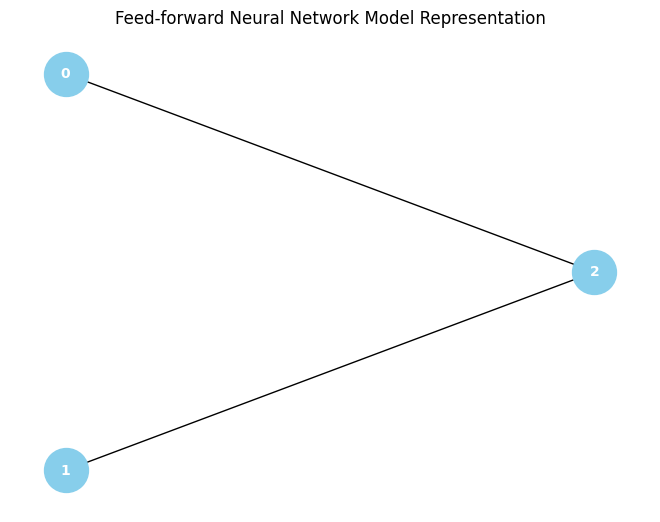

Raw final results:  [[-11.0], [-8.0], [-5.0], [-2.0], [1.0], [4.0], [7.0], [10.0], [13.0], [16.0]]
Expected results:  [[-11], [-8], [-5], [-2], [1], [4], [7], [10], [13], [16]]
Max SSE:  1e-12 , SSE:  0.0
The model is valid as the error is less than or the same as the maximum SSE


In [ ]:
# For linear.json testcase
src_name = "testcase/linear.json"
inferenceData(src_name, False)

Test case relu

Node counts for all layers in the model:  [2, 3]
Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {3: 0.1, 4: 0.2, 5: 0.3}
    1      |   input    |     0      |            | {3: 0.47, 4: -0.6, 5: 0.2}
    2      |   input    |     0      |            | {3: 1.1, 4: -1.3, 5: 0.5}
    3      |   output   |     1      |    relu    |     {}    
    4      |   output   |     1      |    relu    |     {}    
    5      |   output   |     1      |    relu    |     {}    
---------------------------------------------------
Expected Results:  [[0.31, 0, 0.375]]
Max SSE:  1e-06


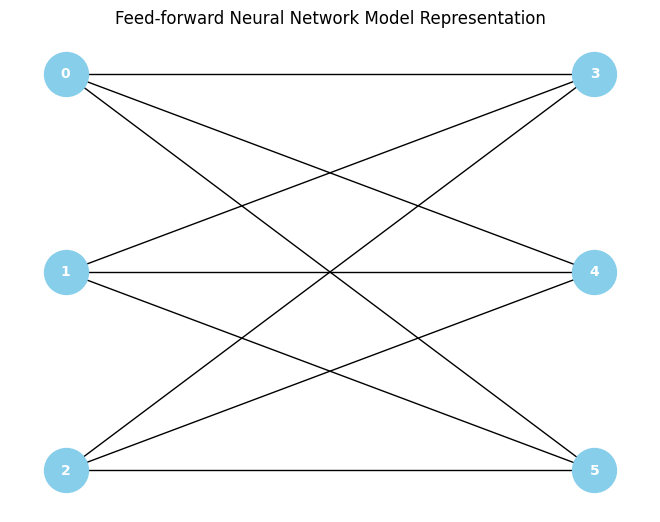

Raw final results:  [[0.3099999999999999, 0.0, 0.3750000000000001]]
Expected results:  [[0.31, 0, 0.375]]
Max SSE:  1e-06 , SSE:  2.465190328815662e-32
The model is valid as the error is less than or the same as the maximum SSE


In [ ]:
# For ReLU model (relu.json)
src_name = "testcase/relu.json"
inferenceData(src_name, False)

Test case relu di docs

Node counts for all layers in the model:  [2, 3]
Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {3: 0.1, 4: 0.2, 5: 0.3}
    1      |   input    |     0      |            | {3: 0.4, 4: -0.5, 5: 0.6}
    2      |   input    |     0      |            | {3: 0.7, 4: 0.8, 5: -0.9}
    3      |   output   |     1      |    relu    |     {}    
    4      |   output   |     1      |    relu    |     {}    
    5      |   output   |     1      |    relu    |     {}    
---------------------------------------------------
Expected Results:  [[0.05, 1.1, 0.0]]
Max SSE:  1e-06


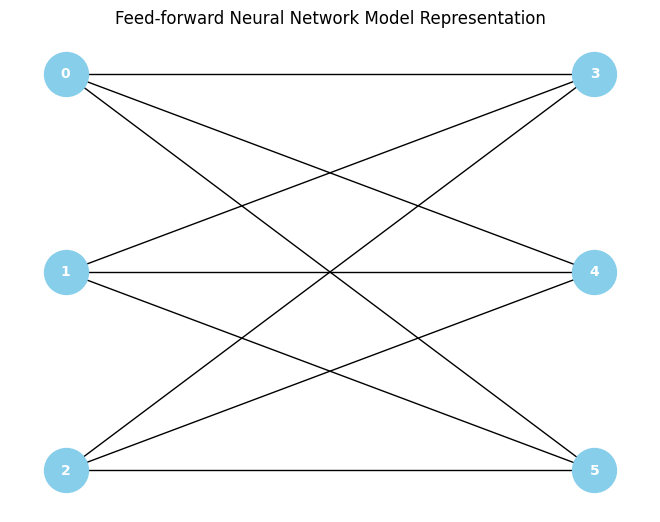

Raw final results:  [[0.04999999999999993, 1.1, 0.0]]
Expected results:  [[0.05, 1.1, 0.0]]
Max SSE:  1e-06 , SSE:  4.8148248609680896e-33
The model is valid as the error is less than or the same as the maximum SSE


In [ ]:
# For ReLU model (reludocs.json)
src_name = "testcase/reludocs.json"
inferenceData(src_name, False)

Test case softmax

Node counts for all layers in the model:  [8, 3]
Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {9: 0.1, 10: 0.9, 11: -0.1}
    1      |   input    |     0      |            | {9: -0.2, 10: 0.8, 11: 0.2}
    2      |   input    |     0      |            | {9: 0.3, 10: -0.7, 11: 0.3}
    3      |   input    |     0      |            | {9: 0.4, 10: 0.6, 11: -0.4}
    4      |   input    |     0      |            | {9: 0.5, 10: 0.5, 11: 0.5}
    5      |   input    |     0      |            | {9: -0.6, 10: 0.4, 11: 0.6}
    6      |   input    |     0      |            | {9: -0.7, 10: -0.3, 11: 0.7}
    7      |   input    |     0      |            | {9: 0.8, 10: 0.2, 11: -0.8}
    8      |   input    |     0      |            | {9: 0.9, 10: -0.1, 11: 0.0}
    9      |   output   |     1      |  softmax   |     {}    
    10     |   output   |  

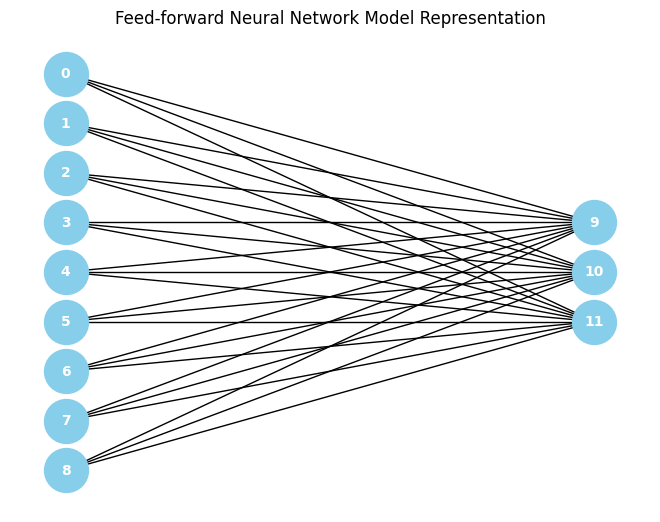

Raw final results:  [[0.7643906087005896, 0.21168068289764497, 0.023928708401765485]]
Expected results:  [[0.76439061, 0.21168068, 0.02392871]]
Max SSE:  1e-05 , SSE:  1.263916713483999e-17
The model is valid as the error is less than or the same as the maximum SSE


In [ ]:
# For Softmax model (softmax.json)
src_name = "testcase/softmax.json"
inferenceData(src_name, False)

Test case multilayer

Node counts for all layers in the model:  [3, 4, 3, 2, 1]
Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {5: 0.1, 6: 0.2, 7: 0.3, 8: -1.2}
    1      |   input    |     0      |            | {5: -0.5, 6: 0.6, 7: 0.7, 8: 0.5}
    2      |   input    |     0      |            | {5: 0.9, 6: 1.0, 7: -1.1, 8: -1.0}
    3      |   input    |     0      |            | {5: 1.3, 6: 1.4, 7: 1.5, 8: 0.1}
    4      |    bias    |     1      |    relu    | {10: 0.1, 11: 0.1, 12: 0.3}
    5      |   hidden   |     1      |    relu    | {10: -0.4, 11: 0.5, 12: 0.6}
    6      |   hidden   |     1      |    relu    | {10: 0.7, 11: 0.4, 12: -0.9}
    7      |   hidden   |     1      |    relu    | {10: 0.2, 11: 0.3, 12: 0.4}
    8      |   hidden   |     1      |    relu    | {10: -0.1, 11: 0.2, 12: 0.1}
    9      |    bias    |     2      |    relu    | {1

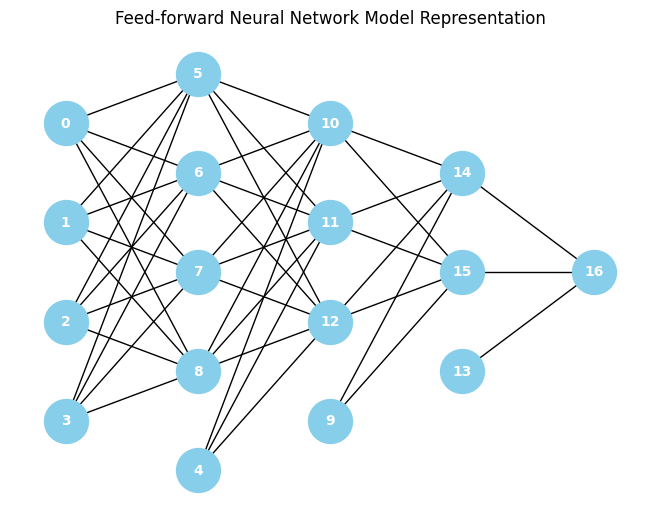

Raw final results:  [[0.4846748017763878]]
Expected results:  [[0.48467479999999996]]
Max SSE:  1e-06 , SSE:  3.15555366793979e-18
The model is valid as the error is less than or the same as the maximum SSE


In [ ]:
# For Multilayer model (multilayer.json)
src_name = "testcase/multilayer.json"
inferenceData(src_name, False)

Test case multilayer softmax

Node counts for all layers in the model:  [4, 4, 4, 4, 2]
Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {6: -0.9, 7: 1.2, 8: -0.6, 9: 0.3}
    1      |   input    |     0      |            | {6: 0.8, 7: -0.7, 8: 1.1, 9: -1.2}
    2      |   input    |     0      |            | {6: 0.3, 7: -1.4, 8: 0.7, 9: 1.2}
    3      |   input    |     0      |            | {6: 1.1, 7: -1.3, 8: 0.9, 9: 0.4}
    4      |   input    |     0      |            | {6: 0.5, 7: -0.8, 8: 1.4, 9: -0.9}
    5      |    bias    |     1      |    relu    | {11: 0.7, 12: -1.1, 13: 0.2, 14: -1.4}
    6      |   hidden   |     1      |    relu    | {11: 1.3, 12: -0.6, 13: 0.5, 14: -1.3}
    7      |   hidden   |     1      |    relu    | {11: -1.2, 12: 0.9, 13: 1.4, 14: -0.7}
    8      |   hidden   |     1      |    relu    | {11: 0.6, 12: -0.5, 13: 1.2, 14: -1.1}
    

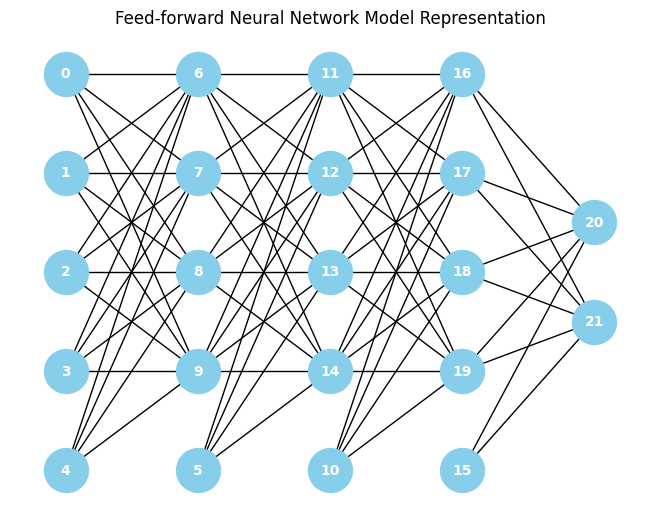

Raw final results:  [[0.7042293996883686, 0.2957706003116313]]
Expected results:  [[0.7042294, 0.2957706]]
Max SSE:  1e-06 , SSE:  1.942282085801731e-19
The model is valid as the error is less than or the same as the maximum SSE


In [ ]:
# For Multilayer model (multilayer.json)
src_name = "testcase/multilayer_softmax.json"
inferenceData(src_name, False)

Test case export and load from and to JSON file (multilayer model)

Node counts for all layers in the model:  [3, 4, 3, 2, 1]
Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {5: 0.1, 6: 0.2, 7: 0.3, 8: -1.2}
    1      |   input    |     0      |            | {5: -0.5, 6: 0.6, 7: 0.7, 8: 0.5}
    2      |   input    |     0      |            | {5: 0.9, 6: 1.0, 7: -1.1, 8: -1.0}
    3      |   input    |     0      |            | {5: 1.3, 6: 1.4, 7: 1.5, 8: 0.1}
    4      |    bias    |     1      |    relu    | {10: 0.1, 11: 0.1, 12: 0.3}
    5      |   hidden   |     1      |    relu    | {10: -0.4, 11: 0.5, 12: 0.6}
    6      |   hidden   |     1      |    relu    | {10: 0.7, 11: 0.4, 12: -0.9}
    7      |   hidden   |     1      |    relu    | {10: 0.2, 11: 0.3, 12: 0.4}
    8      |   hidden   |     1      |    relu    | {10: -0.1, 11: 0.2, 12: 0.1}
    9      |    bias    |     2      |    relu    | {1

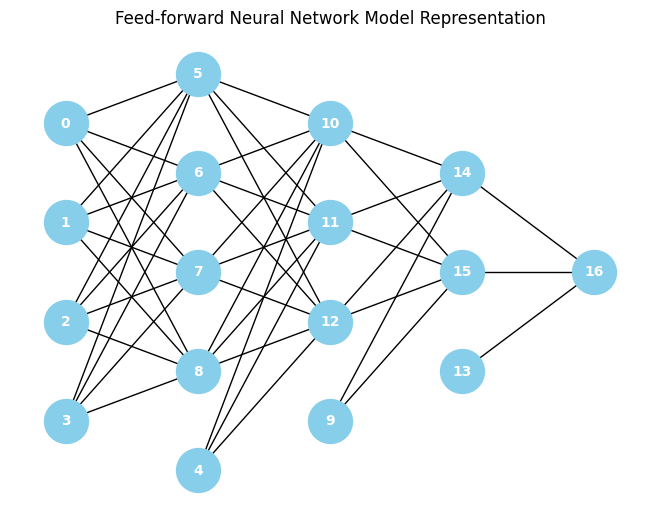

Raw final results:  [[0.4846748017763878]]
Expected results:  [[0.48467479999999996]]
Max SSE:  1e-06 , SSE:  3.15555366793979e-18
The model is valid as the error is less than or the same as the maximum SSE


In [ ]:
multilayer_model = inferenceData("testcase/multilayer.json", True)
multilayer_model.exportToJSON("exports/multilayer_model.json")

Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {'5': 0.1, '6': 0.2, '7': 0.3, '8': -1.2}
    1      |   input    |     0      |            | {'5': -0.5, '6': 0.6, '7': 0.7, '8': 0.5}
    2      |   input    |     0      |            | {'5': 0.9, '6': 1.0, '7': -1.1, '8': -1.0}
    3      |   input    |     0      |            | {'5': 1.3, '6': 1.4, '7': 1.5, '8': 0.1}
    4      |    bias    |     1      |    relu    | {'10': 0.1, '11': 0.1, '12': 0.3}
    5      |   hidden   |     1      |    relu    | {'10': -0.4, '11': 0.5, '12': 0.6}
    6      |   hidden   |     1      |    relu    | {'10': 0.7, '11': 0.4, '12': -0.9}
    7      |   hidden   |     1      |    relu    | {'10': 0.2, '11': 0.3, '12': 0.4}
    8      |   hidden   |     1      |    relu    | {'10': -0.1, '11': 0.2, '12': 0.1}
    9      |    bias    |     2      |    relu    

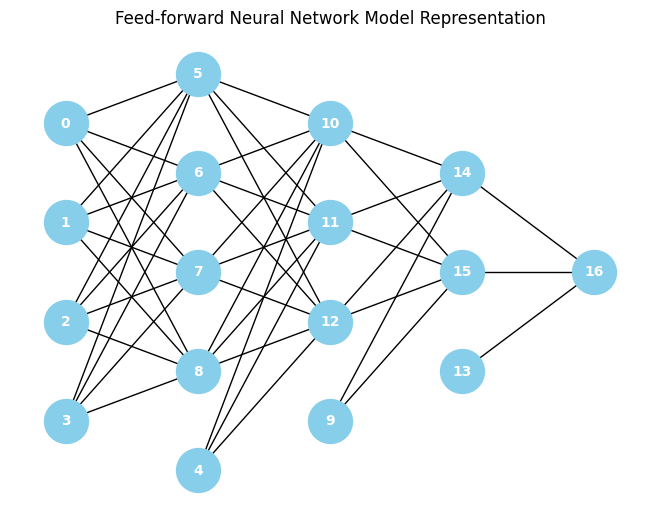

In [ ]:
# Load a model from JSON
new_multilayer_model = Model(0, 0, [], [], 0)
new_multilayer_model = new_multilayer_model.loadJSON("exports/multilayer_model.json")
new_multilayer_model.printModelSummary()
new_multilayer_model.printModelVisualization()